# WH 5

Task: use 2 different clustering methods and choose the best number of clusters.

Data: `clustering.csv`

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
fig_size = 12, 8

In [2]:
df = pd.read_csv('clustering.csv', names=['x','y'])
df.head(3)

,x,y
0,41.788907,52.220182
1,-96.586516,90.957033
2,-54.143591,-99.153377


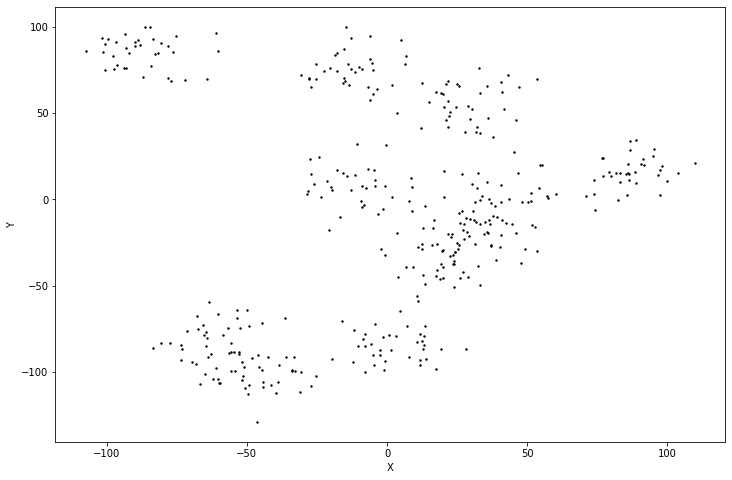

In [3]:
def plot_data(df):
    plt.scatter(df.x, df.y, c='k', s=2)
    plt.xlabel('X')
    plt.ylabel('Y')

plt.figure(figsize=fig_size)
plot_data(df)

By looking at the scatterplot of all points, a few clusters are clearly visible. My guess is that 8 clusters will be the best numer of clusters.

I will test K-Means and Agglomerative clustering. 

# K-means

In [4]:
from sklearn.cluster import KMeans

# 8 clusters is my guess
kmeans = KMeans(n_clusters=8, random_state=97, max_iter=1000) 
kmeans.fit(df)

KMeans(max_iter=1000, random_state=97)

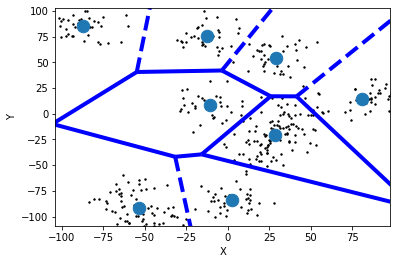

In [5]:
from scipy.spatial import Voronoi, voronoi_plot_2d
fig = voronoi_plot_2d(Voronoi(kmeans.cluster_centers_), point_size=25, show_vertices=False, line_colors='blue', line_width=4)
plot_data(df)

Note: dashed lines are infinite, solid lines are finite ;)

Clusters are as expected, but how about automating selection of number of clusters? Let's copy-paste some code from last labs.

2 methods will be used here: The Elbow Method and Silhouette Score. 

## The elbow method

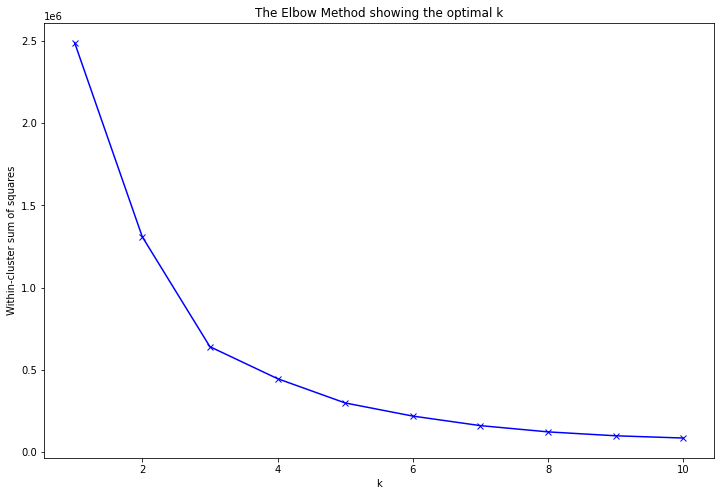

In [6]:
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores
    
wcss_vec = count_wcss_scores(df, 10)
x_ticks = list(range(1, len(wcss_vec) + 1))
f = plt.figure(figsize=fig_size)
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From the plot above, it is unclear which k is the best => line is too smooth to let a human eye easily choose. Maybe k=3 is the best? Let's check silhouette score below.

## Silhouette score

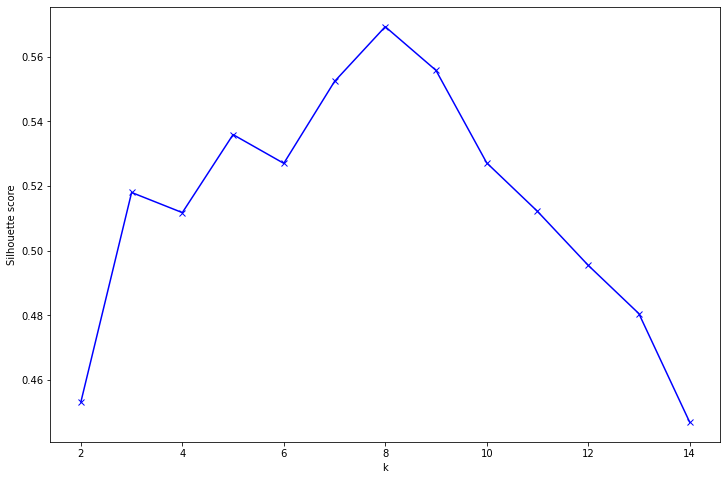

In [7]:
from sklearn.metrics import silhouette_score

cluster_num_iter = range(2, 15)
scores = []    
for k in cluster_num_iter:
    model_instance = KMeans(n_clusters=k, random_state=97)
    labels = model_instance.fit_predict(df)
    silh_score = silhouette_score(df, labels)
    scores.append(silh_score)

f = plt.figure(figsize=fig_size)
plt.plot(cluster_num_iter, scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

Plot above is a proof that my guess was correct - 8 clusters have the highest silhouette score and therefore it is the best number of clusters. When there where 3 clusters, the score was not that bad although k=8 is a bit better. Note that y is from 0.46-0.56 and the differences are relatively small.

# Agglomerative Clustering with ward linkage

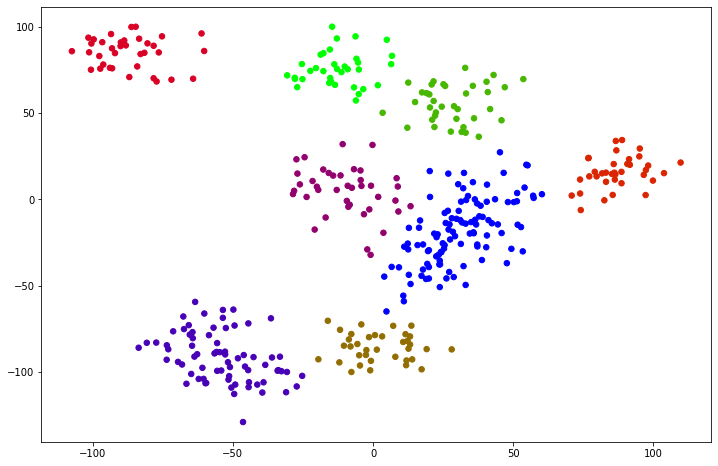

In [8]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=8, linkage='ward')
y_pred = model.fit_predict(df)
f = plt.figure(figsize=fig_size)
plt.scatter(df.x, df.y, c=y_pred, s=30, cmap='brg')
plt.show()


When my guessed number of clusters was set to 8, the result is the same as using KMeans. Next I will check a few metrics, code is copied from labs - it is awesome ;)

In [9]:
X = np.array(df)

In [10]:
from scipy.spatial import distance
import numpy as np

def count_clustering_scores(X, cluster_num, model_class, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
    scores = []    
    for k in cluster_num_iter:
        model_instance = model_class(n_clusters=k, linkage='ward')
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

print('')
print(f'Minimal distance between clusters = {count_clustering_scores(X, 8, AgglomerativeClustering, min_interclust_dist):.2f}.')
print(f'Average distance between points in the same class = '
      f'{count_clustering_scores(X, 8, AgglomerativeClustering, mean_inclust_dist):.2f}.')
print(f'Standard deviation of distance between points in the same class = '
      f'{count_clustering_scores(X, 8, AgglomerativeClustering, std_dev_of_inclust_dist):.3f}.')
print(f'Average distance to cluster center = '
      f'{count_clustering_scores(X, 8, AgglomerativeClustering, mean_dist_to_center):.2f}.')
print('')



Minimal distance between clusters = 8.66.
Average distance between points in the same class = 20.71.
Standard deviation of distance between points in the same class = 3.979.
Average distance to cluster center = 14.59.



Above, some stats for AgglomerativeClustering with linage=ward and n. of clusters = 8 are presented. There is no comparison so they are currently meaningless. To fix it, I will check these metrics fro differing number of clusters.

Plots below present the same metrics as above but for different number of clusters.

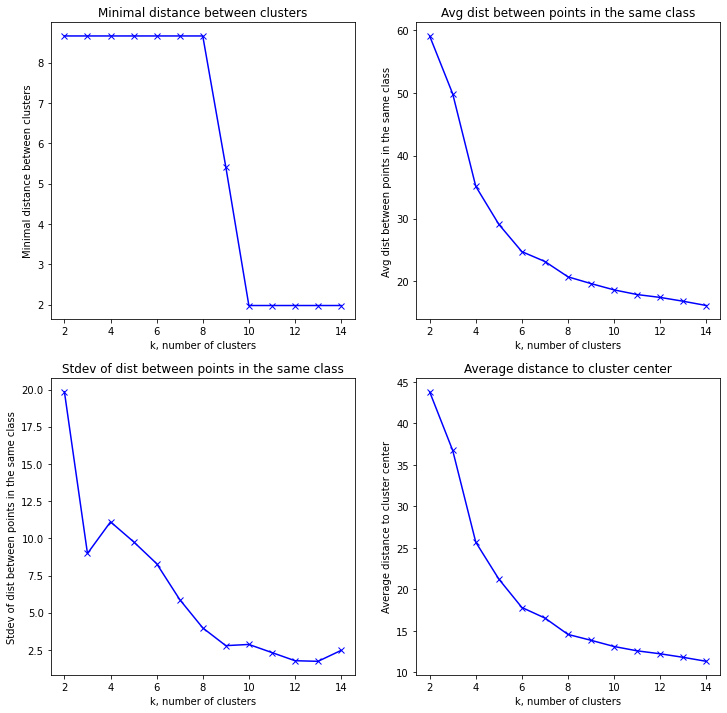

In [11]:
def make_plot(ax, cluster_num_seq, scoring, title):
    scores_vec = count_clustering_scores(np.array(df), cluster_num_seq, AgglomerativeClustering, scoring)
    ax.plot(cluster_num_seq, scores_vec, 'bx-')
    plt.setp(ax, xlabel="k, number of clusters", ylabel=title, title=title)
    
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(12,12))
clust_nums = range(2,15)
make_plot(ax1, clust_nums, min_interclust_dist, "Minimal distance between clusters")
make_plot(ax2, clust_nums, mean_inclust_dist, "Avg dist between points in the same class")
make_plot(ax3, clust_nums, std_dev_of_inclust_dist, "Stdev of dist between points in the same class")
make_plot(ax4, clust_nums, mean_dist_to_center, "Average distance to cluster center")

Yay, plots! 

These plots can be used in the same way as in the elbow rule - we can stare at them and find right value of k.

1. The first plot says that for k>8, some clusters are very close, much closer than before. So we know that k<=8.

2. The second plot is... unclear. Maybe k=6 is different than others, but we won't know more from this plot.

3. Third plot says an interesting thing: stdev for k=3 is lower than for k=4 or k=5, so we might verify this k=3 later. For k>8 the plot is close to flat.

4. Wait... is this the same plot as the second one? Well.. Nonetheless, nothing new is here.

### Conclusion

check k=3, k=6 and k=8.

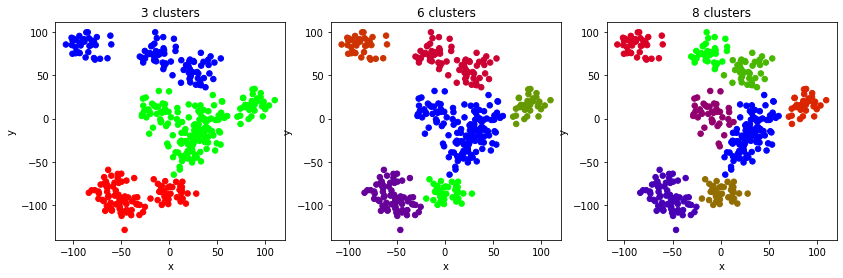

In [12]:
fig_size = 14,4
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=fig_size)

def make_plot_k(ax, clusters_num):
    y_pred = AgglomerativeClustering(n_clusters=clusters_num, linkage='ward').fit_predict(df)
    ax.scatter(df.x, df.y, c=y_pred, s=30, cmap='brg')
    plt.setp(ax, xlabel="x", ylabel="y", title=f'{clusters_num} clusters')
    
make_plot_k(ax1, 3)
make_plot_k(ax2, 6)
make_plot_k(ax3, 8)


Here, k=3 looks strange, k=6 looks ok, k=8 looks the best.

# Conclusion

Plots are useful but may be insufficient to choose the right number of clusters (see Agglomerative Clustering). This is why other metrics such as silhouette score may come in handy.